In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Problem 4

In [2]:
diabetes = pd.read_csv('../data/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Split the data
X, y = diabetes.drop('Outcome', axis=1), diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691, 8), (77, 8), (691,), (77,))

In [4]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# print the accuracy score of the model
print(f'Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Testing Accuracy: {dt.score(X_test, y_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.7662337662337663


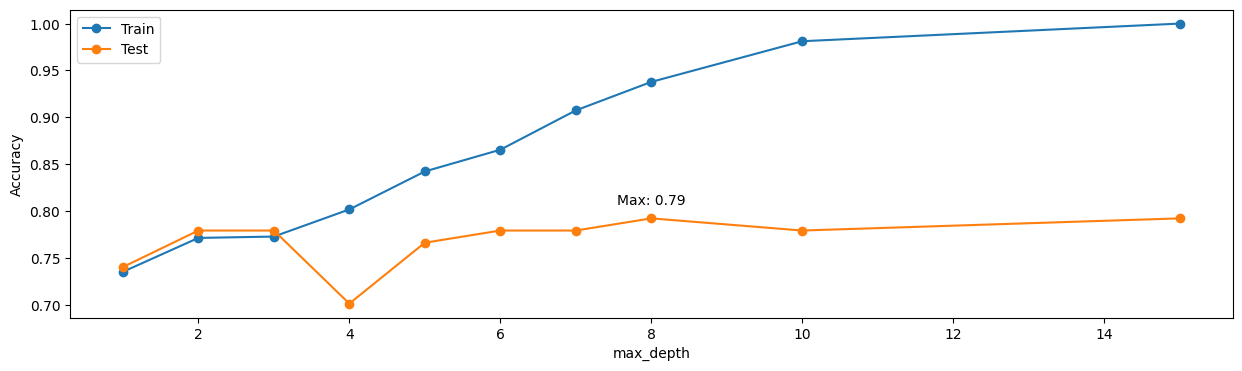

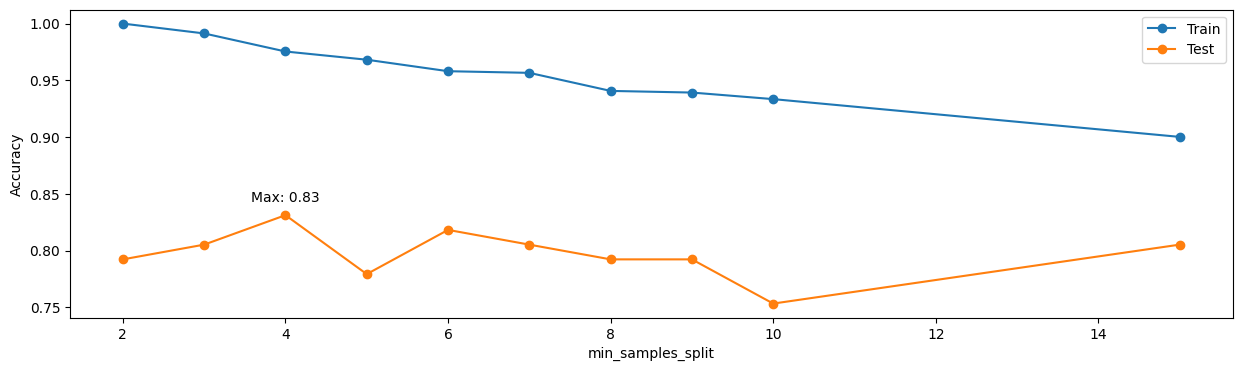

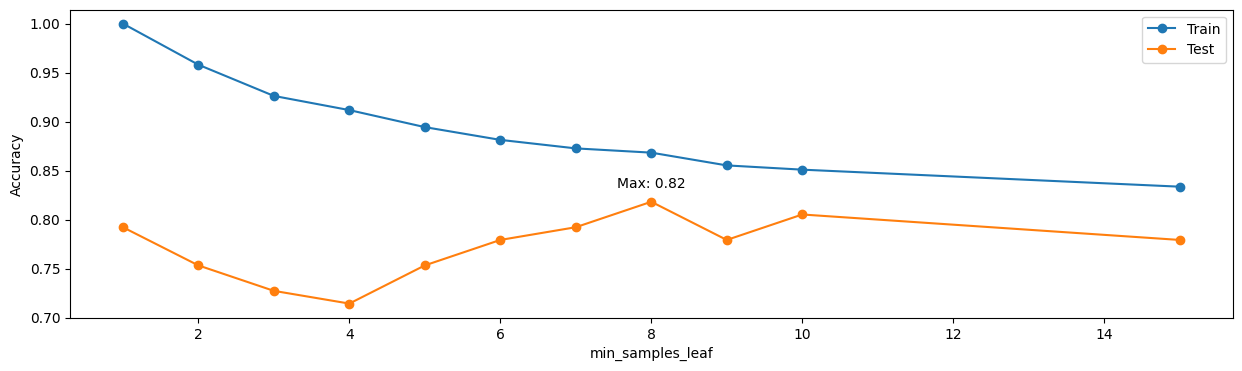

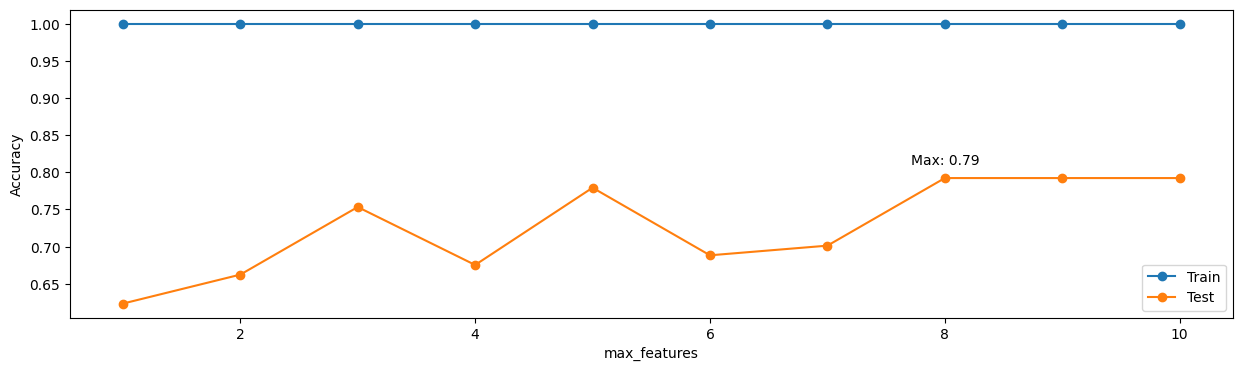

In [5]:
# Regularization
def regularize_tree(param, values):
    train_scores = []
    test_scores = []

    for value in values:
        dt = DecisionTreeClassifier(**{param: value}, random_state=0)
        dt.fit(X_train, y_train)
        train_scores.append(dt.score(X_train, y_train))
        test_scores.append(dt.score(X_test, y_test))
        
    plt.figure(figsize=(15, 4))
    plt.plot(values, train_scores, label='Train', marker='o')
    plt.plot(values, test_scores, label='Test', marker='o')
    plt.annotate(f'Max: {np.round(np.max(test_scores), 2)}', (values[np.argmax(test_scores)], np.max(test_scores)), 
                 textcoords='offset points', xytext=(0, 10), ha='center')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


param_dict = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 10, 15],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

for param, values in param_dict.items():
    regularize_tree(param, values)


In [6]:
# Train a Decision Tree Classifier with the best parameters
dt = DecisionTreeClassifier(min_samples_split=4, random_state=0)
dt.fit(X_train, y_train)

# Print the accuracy score of the model
print(f'Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Testing Accuracy: {dt.score(X_test, y_test)}')

Training Accuracy: 0.975397973950796
Testing Accuracy: 0.8311688311688312


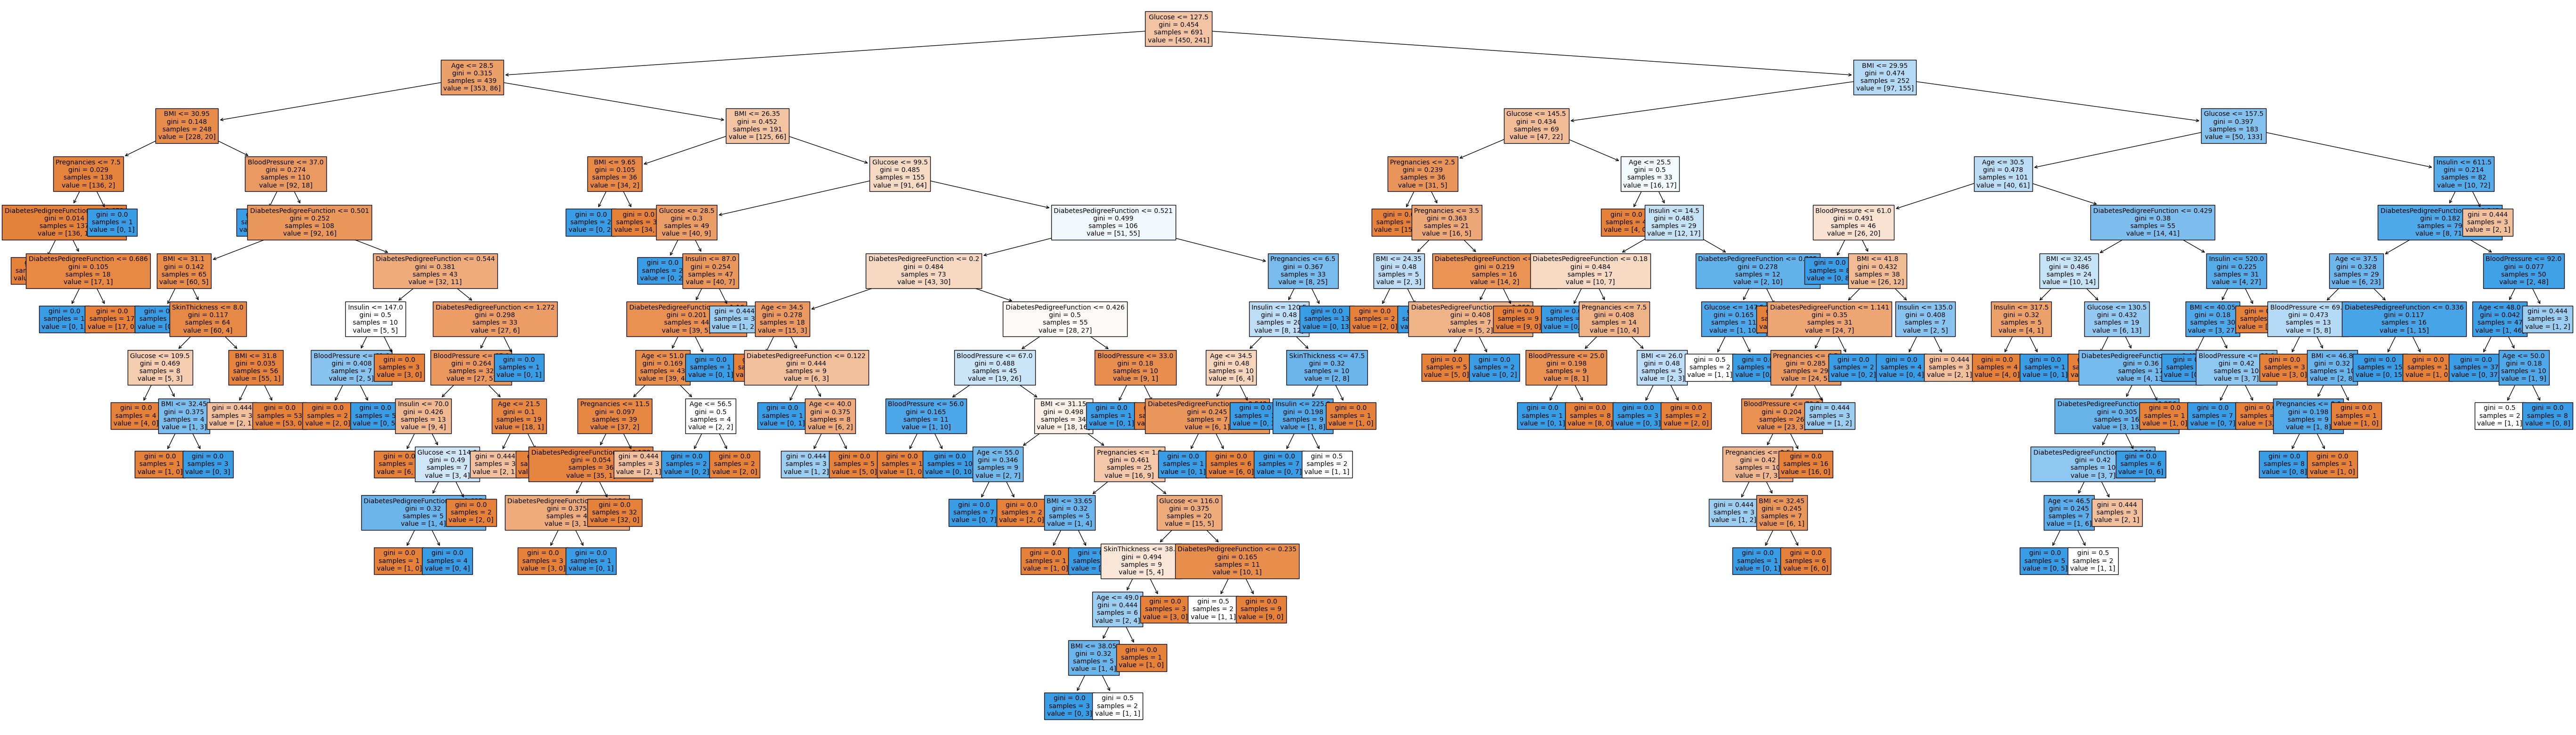

In [7]:
# Visualize the tree
plt.figure(figsize=(70, 20))
plot_tree(dt, filled=True, fontsize=10, feature_names=X_train.columns.tolist())
plt.show()

# Problem 5

In [8]:
class Node:
    """A simple Decision Tree Node."""
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(sample, self.root) for sample in X])

    def _gini(self, y):
        """Compute the Gini Impurity of a dataset."""
        classes = np.unique(y)
        impurity = 1
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            impurity -= p_cls ** 2
        return impurity

    def _best_split(self, X, y):
        """Find the best split for a node."""
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in np.unique(y)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * len(np.unique(y))
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(len(num_left)))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(len(num_right)))
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        """Builds the Decision Tree recursively."""
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        # Implementing stopping criteria
        if depth < self.max_depth and len(y) >= self.min_samples_split:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]

                # Only split if it leads to non-empty branches
                if len(y_left) > 0 and len(y_right) > 0:
                    node.feature_index = idx
                    node.threshold = thr
                    node.left = self._build_tree(X_left, y_left, depth + 1)
                    node.right = self._build_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, sample, node):
        """Predicts the class for a single sample."""
        while node.left:
            if sample[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

def accuracy(y_true, y_pred):
    """Computes the accuracy of the predictions."""
    return np.mean(y_true == y_pred)

In [9]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=4)
clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

print(f'Accuracy on the training set: {accuracy(y_train, clf.predict(X_train.values)):.3f}')
print(f'Accuracy on the testing set: {accuracy(y_test, y_pred):.3f}')

Accuracy on the training set: 0.771
Accuracy on the testing set: 0.779
